<h1 align=center><font size = 5>Appropriate Neighborhood for Immigrants in New York City</font></h1>

## Introduction

In this project, we shall convert addresses into their equivalent latitude and longitude values. Also, we shall use the Foursquare API to explore neighborhoods in New York City. You will use the **explore** function to get the most common venue categories in each neighborhood, and then use this feature to group the neighborhoods into clusters. We shall use the *k*-means clustering algorithm to complete this task. Finally, we shall use the Folium library to visualize the neighborhoods in New York City and their emerging clusters.

Idea here is that immigrants need help in trying to find an appropriate neighborhood at least during the initial years of settlement. Current means of selection is solely based on contact(s) they may have in New York or based on employer provided information, which in most cases may not suffice.

Our endeavor is to provide the above service on-line to help the Immigrants make a right choice.


## Table of Contents

<div class="alert alert-block alert-info" style="margin-top: 20px">

<font size = 3>

1. <a href="#item1">Download and Explore Dataset</a>

2. <a href="#item2">Explore Neighborhoods in New York City</a>

3. <a href="#item3">Analyze Each Neighborhood</a>

4. <a href="#item4">Cluster Neighborhoods</a>

5. <a href="#item5">Examine Clusters</a>    
</font>
</div>

Import all the dependenceis

In [3]:
import numpy as np # library to handle data in a vectorized manner
import pandas as pd # library for data analsysis

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files
import requests # library to handle requests

from geopy.geocoders import Nominatim # convert an address into latitude and longitude values
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

import folium # map rendering library


## 1. Download and Explore Dataset

Neighborhood has a total of 5 boroughs and 306 neighborhoods. In order to segement the neighborhoods and explore them, we will essentially need a dataset that contains the 5 boroughs and the neighborhoods that exist in each borough as well as the the latitude and logitude coordinates of each neighborhood.


In [4]:
!wget -q -O 'newyork_data.json' https://cocl.us/new_york_dataset
print('Data downloaded!')

Data downloaded!


In [5]:
with open('newyork_data.json') as json_data:
    newyork_data = json.load(json_data)
    
newyork_data

#### Get this into a Pandas DataFrame

In [9]:
neighborhoods_data = newyork_data['features']

# define the dataframe columns
column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 

# instantiate the dataframe
neighborhoods = pd.DataFrame(columns=column_names)

for data in neighborhoods_data:
    borough = neighborhood_name = data['properties']['borough'] 
    neighborhood_name = data['properties']['name']
        
    neighborhood_latlon = data['geometry']['coordinates']
    neighborhood_lat = neighborhood_latlon[1]
    neighborhood_lon = neighborhood_latlon[0]
    
    neighborhoods = neighborhoods.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)

print('The dataframe has {} boroughs and {} neighborhoods.'.format(
        len(neighborhoods['Borough'].unique()),
        neighborhoods.shape[0]
    )
)

The dataframe has 5 boroughs and 306 neighborhoods.


#### Create a map of New York with Neighbourhoods superimposed.

In [10]:
address = 'New York City, NY'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude

# create map of New York using latitude and longitude values
map_newyork = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, borough, neighborhood in zip(neighborhoods['Latitude'], neighborhoods['Longitude'], neighborhoods['Borough'], neighborhoods['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_newyork)  
    
map_newyork

## 2. Explore Neighborhods in Queens

In [11]:
queens_data = neighborhoods[neighborhoods['Borough'] == 'Queens'].reset_index(drop=True)
address = 'Queens, NY'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude

In [12]:
CLIENT_ID = 'K3J00OQU2ADB4OJ4LD4TVS3K55WQYNFYMZDJR32MR40PQEK5' # your Foursquare ID
CLIENT_SECRET = '0H41PANHJVREFY5QOEPQ4X13JKVZPL2DMTDROKJ2VFWYSRN0' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

In [17]:
queens_data['Neighborhood']

0                  Astoria
1                 Woodside
2          Jackson Heights
3                 Elmhurst
4             Howard Beach
5                   Corona
6             Forest Hills
7              Kew Gardens
8            Richmond Hill
9                 Flushing
10        Long Island City
11               Sunnyside
12           East Elmhurst
13                 Maspeth
14               Ridgewood
15                Glendale
16               Rego Park
17               Woodhaven
18              Ozone Park
19        South Ozone Park
20           College Point
21              Whitestone
22                 Bayside
23              Auburndale
24             Little Neck
25              Douglaston
26               Glen Oaks
27               Bellerose
28       Kew Gardens Hills
29           Fresh Meadows
30               Briarwood
31          Jamaica Center
32         Oakland Gardens
33          Queens Village
34                  Hollis
35           South Jamaica
36              St. Albans
3

In [15]:
def getNearbyVenues(names, latitudes, longitudes, radius=500, LIMIT=100):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [18]:

queens_venues = getNearbyVenues(names=queens_data['Neighborhood'],
                                   latitudes=queens_data['Latitude'],
                                   longitudes=queens_data['Longitude']
                                  )


Astoria
Woodside
Jackson Heights
Elmhurst
Howard Beach
Corona
Forest Hills
Kew Gardens
Richmond Hill
Flushing
Long Island City
Sunnyside
East Elmhurst
Maspeth
Ridgewood
Glendale
Rego Park
Woodhaven
Ozone Park
South Ozone Park
College Point
Whitestone
Bayside
Auburndale
Little Neck
Douglaston
Glen Oaks
Bellerose
Kew Gardens Hills
Fresh Meadows
Briarwood
Jamaica Center
Oakland Gardens
Queens Village
Hollis
South Jamaica
St. Albans
Rochdale
Springfield Gardens
Cambria Heights
Rosedale
Far Rockaway
Broad Channel
Breezy Point
Steinway
Beechhurst
Bay Terrace
Edgemere
Arverne
Rockaway Beach
Neponsit
Murray Hill
Floral Park
Holliswood
Jamaica Estates
Queensboro Hill
Hillcrest
Ravenswood
Lindenwood
Laurelton
Lefrak City
Belle Harbor
Rockaway Park
Somerville
Brookville
Bellaire
North Corona
Forest Hills Gardens
Jamaica Hills
Utopia
Pomonok
Astoria Heights
Hunters Point
Sunnyside Gardens
Blissville
Roxbury
Middle Village
Malba
Hammels
Bayswater
Queensbridge


In [24]:
queens_venues.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Astoria,40.768509,-73.915654,Favela Grill,40.767348,-73.917897,Brazilian Restaurant
1,Astoria,40.768509,-73.915654,Orange Blossom,40.769856,-73.917012,Gourmet Shop
2,Astoria,40.768509,-73.915654,Titan Foods Inc.,40.769198,-73.919253,Gourmet Shop
3,Astoria,40.768509,-73.915654,CrossFit Queens,40.769404,-73.918977,Gym
4,Astoria,40.768509,-73.915654,Simply Fit Astoria,40.769114,-73.912403,Gym


In [61]:
# Group the Neighborhoods and count the venues.
nh_group = queens_venues[['Neighborhood', 'Venue']]
nh_grp = nh_group.groupby('Neighborhood', as_index=False).count()
nh_grp.head()
nh_grp.set_index(['Neighborhood'], inplace=True)

Text(0.5, 1.0, 'Number of Venues per Neighborhood')

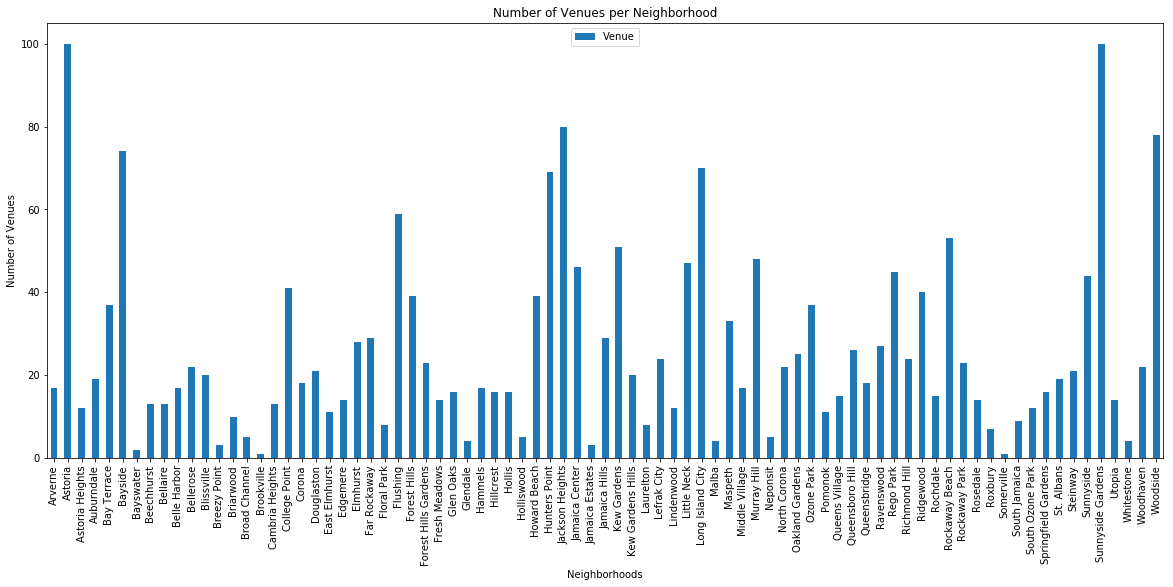

In [44]:
%matplotlib inline
ax = nh_grp.plot(kind='bar', rot=90, figsize=(20,8))
ax.set_xlabel("Neighborhoods")
ax.set_ylabel("Number of Venues")
ax.set_title("Number of Venues per Neighborhood")

People Trying to settle down would look for places with less of activity which translates to less number of venues in the vicinity.
We shall select Negihborhoods having less than 20 venues in them.

In [71]:
#nh_grp.reset_index(inplace=True)
quiet_nh_list = nh_grp[nh_grp['Venue'] < 20]['Neighborhood']
quiet_nh = queens_venues[queens_venues['Neighborhood'].isin(quiet_nh_list)]

In [83]:
quiet_nh['Venue Category'].unique()

array(['Ice Cream Shop', 'Italian Restaurant', 'Mexican Restaurant',
       'Empanada Restaurant', 'Pizza Place', 'Deli / Bodega',
       'South American Restaurant', 'Convenience Store', 'Restaurant',
       'Bakery', 'Donut Shop', 'Park', 'Sandwich Place', 'Supermarket',
       'Church', 'Hotel Bar', 'Rental Car Location', 'Coffee Shop',
       'American Restaurant', 'Lake', 'Gas Station',
       'Arts & Crafts Store', 'Brewery', 'Food & Drink Shop', 'Hotel',
       'Fast Food Restaurant', 'Bar', 'Food Truck', 'Dance Studio',
       'Bubble Tea Shop', 'Candy Store', 'Athletics & Sports',
       'Discount Store', 'Miscellaneous Shop', 'Pharmacy', 'Pet Store',
       'Furniture / Home Store', 'Toy / Game Store', 'Mobile Phone Shop',
       'Hookah Bar', 'Korean Restaurant', 'Noodle House',
       'Sushi Restaurant', 'Indian Restaurant', 'Bagel Shop', 'Bank',
       'Grocery Store', 'Clothing Store', 'Gift Shop', 'Bus Station',
       'Cosmetics Shop', 'Chinese Restaurant',
       'Vege

In [80]:
quiet_nh['Neighborhood'].unique()

array(['Corona', 'East Elmhurst', 'Glendale', 'South Ozone Park',
       'Whitestone', 'Auburndale', 'Glen Oaks', 'Fresh Meadows',
       'Briarwood', 'Queens Village', 'Hollis', 'South Jamaica',
       'St. Albans', 'Rochdale', 'Springfield Gardens', 'Cambria Heights',
       'Rosedale', 'Broad Channel', 'Breezy Point', 'Beechhurst',
       'Edgemere', 'Arverne', 'Neponsit', 'Floral Park', 'Holliswood',
       'Jamaica Estates', 'Hillcrest', 'Lindenwood', 'Laurelton',
       'Belle Harbor', 'Somerville', 'Brookville', 'Bellaire', 'Utopia',
       'Pomonok', 'Astoria Heights', 'Roxbury', 'Middle Village', 'Malba',
       'Hammels', 'Bayswater', 'Queensbridge'], dtype=object)

## 3. Analyze Each Neighborhood

In [84]:
# one hot encoding
queens_onehot = pd.get_dummies(queens_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
queens_onehot['Neighborhood'] = queens_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [queens_onehot.columns[-1]] + list(queens_onehot.columns[:-1])
queens_onehot = queens_onehot[fixed_columns]

queens_onehot.shape

(2104, 268)

In [85]:
queens_grouped = queens_onehot.groupby('Neighborhood').mean().reset_index()
queens_grouped.shape

(81, 268)

Let us Filter our Data to contain only the top 10 Venues.

In [87]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = queens_grouped['Neighborhood']

for ind in np.arange(queens_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(queens_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Arverne,Surf Spot,Metro Station,Sandwich Place,Board Shop,Thai Restaurant,Coffee Shop,Donut Shop,Beach,Bus Stop,Playground
1,Astoria,Bar,Middle Eastern Restaurant,Hookah Bar,Greek Restaurant,Seafood Restaurant,Indian Restaurant,Mediterranean Restaurant,Pizza Place,Food Truck,Bubble Tea Shop
2,Astoria Heights,Deli / Bodega,Playground,Pizza Place,Plaza,Italian Restaurant,Hostel,Bus Station,Burger Joint,Bowling Alley,Bakery
3,Auburndale,Italian Restaurant,Deli / Bodega,Discount Store,Supermarket,Bar,Furniture / Home Store,Korean Restaurant,Fast Food Restaurant,Athletics & Sports,Noodle House
4,Bay Terrace,Clothing Store,Women's Store,Cosmetics Shop,Donut Shop,American Restaurant,Lingerie Store,Shoe Store,Kids Store,Mobile Phone Shop,Furniture / Home Store


In [101]:
temp = queens_grouped.drop(['Neighborhood'],axis=1)
temp.head()

,Yoga Studio,Accessories Store,Afghan Restaurant,American Restaurant,Antique Shop,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Arts & Entertainment,Asian Restaurant,Athletics & Sports,Automotive Shop,BBQ Joint,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Basketball Court,Bath House,Beach,Beach Bar,Beer Garden,Bike Trail,Bistro,Board Shop,Bookstore,Boutique,Bowling Alley,Brazilian Restaurant,Breakfast Spot,Brewery,Bubble Tea Shop,Buffet,Burger Joint,Burrito Place,Bus Line,Bus Station,Bus Stop,Business Service,Butcher,Cafeteria,Café,Cajun / Creole Restaurant,Candy Store,Cantonese Restaurant,Caribbean Restaurant,Check Cashing Service,Chinese Restaurant,Church,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Academic Building,College Basketball Court,College Cafeteria,Colombian Restaurant,Comedy Club,Comfort Food Restaurant,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Cuban Restaurant,Cycle Studio,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dive Bar,Dog Run,Donut Shop,Dosa Place,Dry Cleaner,Dumpling Restaurant,Eastern European Restaurant,Egyptian Restaurant,Electronics Store,Empanada Restaurant,Event Space,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Filipino Restaurant,Fish & Chips Shop,Fish Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Truck,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gas Station,Gastropub,Gay Bar,General Entertainment,German Restaurant,Gift Shop,Gluten-free Restaurant,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Halal Restaurant,Hardware Store,Health & Beauty Service,Health Food Store,Himalayan Restaurant,History Museum,Hobby Shop,Home Service,Hookah Bar,Hostel,Hot Dog Joint,Hotel,Hotel Bar,Hotel Pool,Hotpot Restaurant,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indoor Play Area,Intersection,Irish Pub,Italian Restaurant,Japanese Restaurant,Jewelry Store,Juice Bar,Karaoke Bar,Kids Store,Korean Restaurant,Kosher Restaurant,Lake,Latin American Restaurant,Laundromat,Laundry Service,Lingerie Store,Liquor Store,Lounge,Malay Restaurant,Market,Martial Arts Dojo,Massage Studio,Mattress Store,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Monument / Landmark,Moroccan Restaurant,Motel,Motorcycle Shop,Movie Theater,Moving Target,Multiplex,Museum,Music Store,Nail Salon,New American Restaurant,Nightclub,Noodle House,Office,Optical Shop,Organic Grocery,Other Great Outdoors,Other Nightlife,Paper / Office Supplies Store,Park,Pedestrian Plaza,Performing Arts Venue,Peruvian Restaurant,Pet Service,Pet Store,Pharmacy,Photography Studio,Pie Shop,Pier,Pizza Place,Platform,Playground,Plaza,Poke Place,Polish Restaurant,Pool Hall,Post Office,Pub,Ramen Restaurant,Rental Car Location,Rental Service,Residential Building (Apartment / Condo),Resort,Rest Area,Restaurant,Romanian Restaurant,Roof Deck,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,School,Sculpture Garden,Seafood Restaurant,Shanghai Restaurant,Shipping Store,Shoe Store,Shop & Service,Shopping Mall,Shopping Plaza,Skate Park,Skating Rink,Smoke Shop,Snack Place,South American Restaurant,Southern / Soul Food Restaurant,Souvlaki Shop,Spa,Spanish Restaurant,Sporting Goods Shop,Sports Bar,State / Provincial Park,Steakhouse,Storage Facility,Strip Club,Supermarket,Supplement Shop,Surf Spot,Sushi Restaurant,Szechuan Restaurant,Taco Place,Tailor Shop,Taiwanese Restaurant,Tapas Restaurant,Tea Room,Tennis Court,Thai Restaurant,Theater,Thrift / Vintage Store,Tibetan Restaurant,Toy / Game Store,Trail,Train,Train Station,Turkish Restaurant,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Warehouse Store,Weight Loss Center,Wine Bar,Wine Shop,Women's Store
0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000

## 4. Cluster Neighborhood

Before we decide on the number of clusters that we would want to split our neighborhood, let us first try 
to find an optimal cluster number using elbow method.

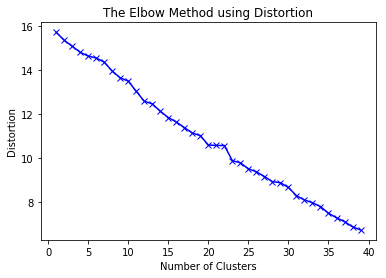

In [104]:
from scipy.spatial.distance import cdist
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt  


distortions = []
K = range(1,40) 

X = StandardScaler().fit_transform(temp)
  
for k in K: 
    #Building and fitting the model 
    kmeanModel = KMeans(n_clusters=k).fit(X) 
    kmeanModel.fit(X)     
      
    distortions.append(sum(np.min(cdist(X, kmeanModel.cluster_centers_, 
                      'euclidean'),axis=1)) / X.shape[0])
    
plt.plot(K, distortions, 'bx-') 
plt.xlabel('Number of Clusters') 
plt.ylabel('Distortion') 
plt.title('The Elbow Method using Distortion') 
plt.show() 

This is suggesting that there is not optimal value that we could find to go with k-means...
We have tried with a range from 10 - 40 and so we shall stick to a observable number whcih is 5.

In [174]:
# set number of clusters
kclusters = 5

queens_grouped_clustering = queens_grouped.drop('Neighborhood', axis=1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(queens_grouped_clustering)

# add clustering labels
if 'Cluster Labels' not in neighborhoods_venues_sorted.columns:
    neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)
else:
    neighborhoods_venues_sorted['Cluster Labels'] = kmeans.labels_

queens_merged = queens_data

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
queens_merged = queens_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

queens_merged.head() # check the last columns!

,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Queens,Astoria,40.768509,-73.915654,0,Bar,Middle Eastern Restaurant,Hookah Bar,Greek Restaurant,Seafood Restaurant,Indian Restaurant,Mediterranean Restaurant,Pizza Place,Food Truck,Bubble Tea Shop
1,Queens,Woodside,40.746349,-73.901842,0,Grocery Store,Filipino Restaurant,Latin American Restaurant,Bakery,Thai Restaurant,Pizza Place,Bar,Donut Shop,Pub,American Restaurant
2,Queens,Jackson Heights,40.751981,-73.882821,0,Latin American Restaurant,Peruvian Restaurant,South American Restaurant,Bakery,Mobile Phone Shop,Thai Restaurant,Mexican Restaurant,Pizza Place,Supplement Shop,Empanada Restaurant
3,Queens,Elmhurst,40.744049,-73.881656,0,Thai Restaurant,Mexican Restaurant,South American Restaurant,Vietnamese Restaurant,Chinese Restaurant,Pizza Place,Gym / Fitness Center,Food Court,Snack Place,Bubble Tea Shop
4,Queens,Howard Beach,40.654225,-73.838138,0,Italian Restaurant,Pharmacy,Sandwich Place,Chinese Restaurant,Bank,Bagel Shop,Fast Food Restaurant,Indoor Play Area,Shipping Store,Seafood Restaurant


VIsualising the thus created clusters...

In [175]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(queens_merged['Latitude'], queens_merged['Longitude'], queens_merged['Neighborhood'], queens_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

## Examine the Clusters

### Cluster 0

In [176]:
c0 = queens_merged.loc[queens_merged['Cluster Labels'] == 0, queens_merged.columns[[1] + list(range(5, queens_merged.shape[1]))]]
c0

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Astoria,Bar,Middle Eastern Restaurant,Hookah Bar,Greek Restaurant,Seafood Restaurant,Indian Restaurant,Mediterranean Restaurant,Pizza Place,Food Truck,Bubble Tea Shop
1,Woodside,Grocery Store,Filipino Restaurant,Latin American Restaurant,Bakery,Thai Restaurant,Pizza Place,Bar,Donut Shop,Pub,American Restaurant
2,Jackson Heights,Latin American Restaurant,Peruvian Restaurant,South American Restaurant,Bakery,Mobile Phone Shop,Thai Restaurant,Mexican Restaurant,Pizza Place,Supplement Shop,Empanada Restaurant
3,Elmhurst,Thai Restaurant,Mexican Restaurant,South American Restaurant,Vietnamese Restaurant,Chinese Restaurant,Pizza Place,Gym / Fitness Center,Food Court,Snack Place,Bubble Tea Shop
4,Howard Beach,Italian Restaurant,Pharmacy,Sandwich Place,Chinese Restaurant,Bank,Bagel Shop,Fast Food Restaurant,Indoor Play Area,Shipping Store,Seafood Restaurant
6,Forest Hills,Gym,Gym / Fitness Center,Yoga Studio,Asian Restaurant,Pizza Place,Convenience Store,Park,Thai Restaurant,Pharmacy,Donut Shop
7,Kew Gardens,Chinese Restaurant,Cosmetics Shop,Bar,Park,Deli / Bodega,Juice Bar,Pizza Place,Indian Restaurant,Donut Shop,Bank
8,Richmond Hill,Pizza Place,Lounge,Latin American Restaurant,Bank,Donut Shop,Sandwich Place,Caribbean Restaurant,Clothing Store,Metro Station,Gym / Fitness Center
9,Flushing,Korean Restaurant,Bubble Tea Shop,Chinese Restaurant,Hotpot Restaurant,Karaoke Bar,Bakery,Sushi Restaurant,Szechuan Restaurant,Food,Gym
10,Long Island City,Hotel,Coffee Shop,Bar,Pizza Place,Mexican Restaurant,Café,Gym / Fitness Center,Supermarket,Post Office,Convenience Store


### Cluster 1

In [177]:
c1 = queens_merged.loc[queens_merged['Cluster Labels'] == 1, queens_merged.columns[[1] + list(range(5, queens_merged.shape[1]))]]
c1

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
64,Brookville,Deli / Bodega,Women's Store,Fish & Chips Shop,Event Space,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Filipino Restaurant,Fish Market


### Cluster 2

In [178]:
c2 = queens_merged.loc[queens_merged['Cluster Labels'] == 2, queens_merged.columns[[1] + list(range(5, queens_merged.shape[1]))]]
c2

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
43,Breezy Point,Monument / Landmark,Trail,Beach,Women's Store,Fast Food Restaurant,Event Space,Falafel Restaurant,Farm,Farmers Market,Filipino Restaurant
50,Neponsit,Beach,Bar,Women's Store,Filipino Restaurant,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Fish & Chips Shop,Fried Chicken Joint
78,Hammels,Beach,Fried Chicken Joint,Gym / Fitness Center,Diner,Dog Run,Fast Food Restaurant,Shoe Store,Café,Bus Stop,Bus Station


### Cluster 3

In [179]:
c3 = queens_merged.loc[queens_merged['Cluster Labels'] == 3, queens_merged.columns[[1] + list(range(5, queens_merged.shape[1]))]]
c3

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
63,Somerville,Park,Women's Store,Food Court,Food & Drink Shop,Food,Flower Shop,Fish Market,Fish & Chips Shop,Filipino Restaurant,Fast Food Restaurant
79,Bayswater,Playground,Park,Women's Store,Farmers Market,Electronics Store,Empanada Restaurant,Event Space,Falafel Restaurant,Farm,Filipino Restaurant


### Cluster 4

In [180]:
c4 = queens_merged.loc[queens_merged['Cluster Labels'] == 4, queens_merged.columns[[1] + list(range(5, queens_merged.shape[1]))]]
c4

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
5,Corona,Mexican Restaurant,Convenience Store,Bakery,Ice Cream Shop,Pizza Place,Deli / Bodega,Sandwich Place,Church,Italian Restaurant,South American Restaurant
12,East Elmhurst,Donut Shop,Lake,Hotel Bar,American Restaurant,Ice Cream Shop,Pizza Place,Rental Car Location,Coffee Shop,Gas Station,Supermarket
17,Woodhaven,Deli / Bodega,Bank,Pharmacy,Donut Shop,Bus Station,Pizza Place,Nail Salon,Supermarket,Sandwich Place,Latin American Restaurant
19,South Ozone Park,Park,Fast Food Restaurant,Deli / Bodega,Donut Shop,Bar,Hotel,Food Truck,Sandwich Place,Event Space,Falafel Restaurant
20,College Point,Deli / Bodega,Pizza Place,Bakery,Chinese Restaurant,Latin American Restaurant,Karaoke Bar,Seafood Restaurant,Mediterranean Restaurant,Buffet,Sandwich Place
21,Whitestone,Dance Studio,Candy Store,Bubble Tea Shop,Deli / Bodega,Department Store,Dessert Shop,Food Truck,Food Court,Food & Drink Shop,Food
24,Little Neck,Chinese Restaurant,Korean Restaurant,Italian Restaurant,Deli / Bodega,Bakery,Japanese Restaurant,Coffee Shop,Spa,Bank,Bubble Tea Shop
25,Douglaston,Deli / Bodega,Bank,Spa,Bakery,Convenience Store,Pharmacy,Diner,Donut Shop,Chinese Restaurant,Fast Food Restaurant
27,Bellerose,Deli / Bodega,Pizza Place,Italian Restaurant,Mobile Phone Shop,Bank,Pub,Diner,Donut Shop,Chinese Restaurant,Seafood Restaurant
28,Kew Gardens Hills,Bank,Playground,Bus Station,Pizza Place,Sushi Restaurant,Bagel Shop,Convenience Store,Dance Studio,Deli / Bodega,Restaurant


## Observations

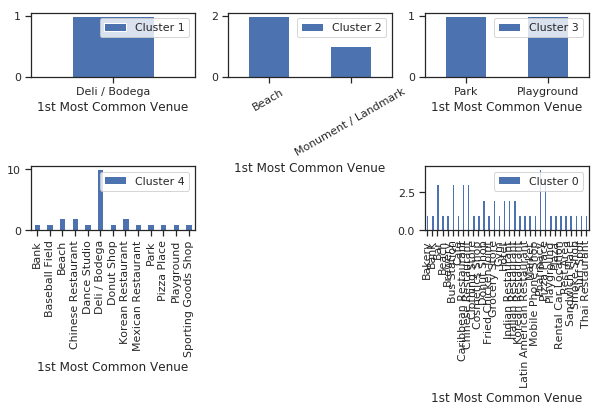

In [196]:
#import matplotlib.pyplot as plt

fig = plt.figure()
ax0 = fig.add_subplot(339)
ax1 = fig.add_subplot(331)
ax2 = fig.add_subplot(332)
ax3 = fig.add_subplot(333)
ax4 = fig.add_subplot(337)


c0_grp = c0[["1st Most Common Venue","Neighborhood"]]
c0_grp = c0_grp.groupby("1st Most Common Venue").count()
c0_grp = c0_grp.rename(columns={'Neighborhood':"Cluster 0"})
c0_grp.plot(kind='bar', rot=90, figsize=(10,4), ax=ax0)

c1_grp = c1[["1st Most Common Venue","Neighborhood"]]
c1_grp = c1_grp.groupby("1st Most Common Venue").count()
c1_grp = c1_grp.rename(columns={'Neighborhood':"Cluster 1"})
c1_grp.plot(kind='bar', rot=0, figsize=(10,4), ax=ax1)

c2_grp = c2[["1st Most Common Venue","Neighborhood"]]
c2_grp = c2_grp.groupby("1st Most Common Venue").count()
c2_grp = c2_grp.rename(columns={'Neighborhood':"Cluster 2"})
c2_grp.plot(kind='bar', rot=30, figsize=(10,4), ax=ax2)

c3_grp = c3[["1st Most Common Venue","Neighborhood"]]
c3_grp = c3_grp.groupby("1st Most Common Venue").count()
c3_grp = c3_grp.rename(columns={'Neighborhood':"Cluster 3"})
c3_grp.plot(kind='bar', rot=0, figsize=(10,4), ax=ax3)

c4_grp = c4[["1st Most Common Venue","Neighborhood"]]
c4_grp = c4_grp.groupby("1st Most Common Venue").count()
c4_grp = c4_grp.rename(columns={'Neighborhood':"Cluster 4"})
c4_grp.plot(kind='bar', rot=90, figsize=(10,4), ax=ax4)


As we can see, from the picture above, Cluster 0 and Cluster 4 contain Neighborhoods that have quite a few number of Venues, while Cluster 1,2,3 are very calm and with less number of venues. They must be mostly vsiting places and not really action packed.

Also by examining the Venues in all the clusters, we cannot draw any conclusion as which cluster is good for what kind of immigrants as most of the venues there are non-specific and those clusters seem to host all kinds of restaurants, (i.e. from different continents/conuntries) and are generic in nature.

However, we could broadly classify Cluster 4 and Cluster 0 for Immigrants.

Cluster 0 seems to have more presence from latin American Conutries with Sporadic presence from China, India and Korea.

Cluster 4 seems to have more presence from Asian & Mediterranian Countries with sporadic presence from Latin American countries.